In [1]:
import requests
import json
import numpy
import pandas

api_key = "PLACEHOLDER"
headers = {'Authorization': 'Bearer %s' % api_key}
url='https://api.yelp.com/v3/businesses/search'
locationType = "Bubble Tea"
city = "Seattle"
params = {'term':locationType,'location':city}
req=requests.get(url, params=params, headers=headers)
req=json.loads(req.text)

In [3]:
total_locations = 20
names = []
addresses = []
ratings = []
urls = []
coordinates = []
images = []
ids = []

for i in range(0, total_locations) :
  name = req["businesses"][i]["name"]
  names.append(name)
  address = req["businesses"][i]["location"]["display_address"]
  addresses.append(address)
  rating = req["businesses"][i]["rating"]
  ratings.append(rating)
  url = req["businesses"][i]["url"]
  urls.append(url)
  coordinate = req["businesses"][i]["coordinates"]
  coordinates.append(coordinate)
  image = req["businesses"][i]["image_url"]
  images.append(image)
  id = req["businesses"][i]["id"]
  ids.append(id)

In [9]:
from sklearn.cluster import KMeans

sanitized_df = pandas.DataFrame(coordinates, columns=["longitude", "latitude"])
location_data = sanitized_df.copy()
location_data.insert(0, 'name', names)
location_data.insert(1, 'address', addresses)
location_data.insert(2, 'rating', ratings)
location_data.insert(3, 'url', urls)
location_data.insert(4, 'image', images)
location_data.insert(5, 'id', id)
kmeans = KMeans(
  init="random",
  n_clusters=10,
  n_init=10,
  max_iter=300,
  random_state=42
)
print(sanitized_df)
kmeans.fit(sanitized_df)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
location_data["cluster"] = kmeans.labels_
centroid_df = pandas.DataFrame(centroids, columns=["cx", "cy"])
centroid_df["cluster"] = range(0, len(centroid_df))
location_data = location_data.merge(centroid_df, left_on='cluster', right_on='cluster')
location_data["distance"] = numpy.sqrt(numpy.square(location_data["cx"] - location_data["longitude"]) + numpy.square(location_data["cy"] - location_data["latitude"]))
location_data["avg_distances"] = location_data.groupby("cluster")["distance"].transform("mean")
location_data = location_data.sort_values("avg_distances")

     longitude   latitude
0  -122.313390  47.661630
1  -122.325970  47.597330
2  -122.319200  47.613350
3  -122.323938  47.598268
4  -122.317201  47.665330
5  -122.355273  47.624012
6  -122.327310  47.598460
7  -122.325910  47.635680
8  -122.322380  47.614800
9  -122.348235  47.649569
10 -122.333901  47.622731
11 -122.313540  47.658070
12 -122.325451  47.598233
13 -122.333120  47.616380
14 -122.317180  47.616910
15 -122.303834  47.618136
16 -122.350314  47.651839
17 -122.313243  47.668404
18 -122.320640  47.620059
19 -122.326770  47.598490


In [12]:
place = 1
best_cluster = location_data["cluster"][place]
threshold = 2
num_in_group = 1
while threshold > num_in_group:
  if best_cluster == location_data["cluster"][place + 1]:
    num_in_group = num_in_group + 1
  else:
    place = 1
    best_cluster = best_cluster + 1
    num_in_group = 1
  place = place + 1
best_result = location_data[location_data["cluster"] == best_cluster]
best_result = best_result.loc[:,["name", "address", "rating", "url", "image", "id"]]
print(best_result)

best_result.set_index("id", drop=True, inplace=True)
final_result = best_result.to_dict(orient="index")
print(final_result)

                      name                                       address  \
2                Young Tea  [609 S Weller St, Unit B, Seattle, WA 98104]   
3                   TP TEA            [679 S King St, Seattle, WA 98104]   
4         Seattle Best Tea            [506 S King St, Seattle, WA 98104]   
5  Yifang Taiwan Fruit Tea            [619 S King St, Seattle, WA 98104]   
6    Yomie's Rice X Yogurt            [518 S King St, Seattle, WA 98104]   

   rating                                                url  \
2     4.5  https://www.yelp.com/biz/young-tea-seattle?adj...   
3     4.0  https://www.yelp.com/biz/tp-tea-seattle?adjust...   
4     4.5  https://www.yelp.com/biz/seattle-best-tea-seat...   
5     3.5  https://www.yelp.com/biz/yifang-taiwan-fruit-t...   
6     4.0  https://www.yelp.com/biz/yomies-rice-x-yogurt-...   

                                               image  
2  https://s3-media3.fl.yelpcdn.com/bphoto/cA4vwp...  
3  https://s3-media3.fl.yelpcdn.com/bphoto/b_5pN

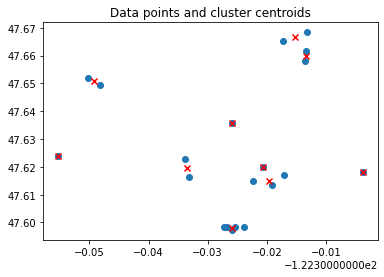

In [13]:
import matplotlib.pyplot as plt
plt.scatter(x=location_data["longitude"], y=location_data["latitude"])
plt.scatter(x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], c='red', marker='x')
plt.title('Data points and cluster centroids')
plt.show()
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(y=[2, 3, 1]))
fig.show()

In [14]:
import pandas
def calculate(location_type, num_locations):
  api_key='MT9rSfKdpGgr2HFQMsZKDNVZxW6KJcnmWd8YtS6Tp0XcVC2uBL02HGB_B9NN43IekQbOjrqRBNCEcZGDblhnvWG7U8Oqdien6YZCy08VR4T4dDz1wNSgW17WV0_mYXYx'
  headers = {'Authorization': 'Bearer %s' % api_key}
  url='https://api.yelp.com/v3/businesses/search'
  city = "Seattle"
  params = {'term':location_type,'location':city}
  req=requests.get(url, params=params, headers=headers)
  req=json.loads(req.text)
  results_list = numpy.empty(shape=num_locations, dtype=object) 
  for i in range(0, num_locations) :
    results_list[i] = req["businesses"][i]["name"]
  results_list = pandas.Series(results_list).to_json(orient='values')
  search_query = location_type
  message = {"searchQuery": search_query, "resultsList": results_list}
  return message

In [15]:
calculate("Bubble Tea", 3)

{'searchQuery': 'Bubble Tea',
 'resultsList': '["Dont Yell At Me","Young Tea","DRIP TEA"]'}